Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 5 </h2>
    <h1> SVM </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Segundo Semestre 2023<br> 
        Fecha de entrega: 3 de noviembre
    </p>
    <br>
</center>

<br>


## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.
- En el caso de que se encuentren con problemas al correr celdas por el tamaño del dataset, esta permitido trabajar con una muestra representativa de este, siempre explicitando y justificando sus deciciones.

---


## Librerías

In [81]:
##Importa acá las librerias que vayas a utilizar
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib as plt
# from lime.lime_text import LimeTextExplainer

# Contexto:

Se tiene un dataset con información de distintas noticias, entre las cuales hay noticias falsas y verdaderas. El objetivo de esta tarea es predecir si una noticia es falsa o verdadera, utilizando distintos modelos de clasificación.. Para esto, primero se debe hacer un análisis exploratorio de los datos para decidir qué variables son relevantes para el problema. Luego, se debe vectorizar el texto de loas noticias para poder utilizarlo en un modelo de clasificación (en esta tarea usaremos SBert y TF-IDF). Después se debe entrenar un modelo de clasificación SVM que prediga si una noticia es falsa o verdadera. Finalmente, se debe evaluar el modelo y compararlo con otros modelos de clasificación.

# Objetivos de la tarea:

- Realizar un análisis exploratorio de datos para determinar las variables pertinentes para el problema en cuestión, identificando características clave y patrones en los datos que podrían afectar la clasificación de las noticias.
- Dominar la técnica de vectorización de texto para facilitar su aplicación en un modelo de clasificación, y comprender la interpretación de los resultados obtenidos.
- Entender el funcionamiento de un modelo de clasificación SVM y sus hiperparámetros.
- Entrenar un modelo de clasificación SVM capaz de predecir si una noticia es falsa o verdadera.
- Evaluar el desempeño del modelo y analizar en profundidad los resultados obtenidos.

# Parte 1: Carga y Preprocesamiento (10 puntos)

## 1.1 Carga de datos (1 punto)

Para esta tarea deberás trabajar con el dataset que está en Canvas, 'news.csv'. Este dataset contiene información de distintas noticias, entre las cuales hay noticias falsas y verdaderas.

In [2]:
data = pd.read_csv('news.csv', sep=',')
data

,title,text,subject,date,authenticity
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
9995,U.S. Agriculture secretary nominee submits eth...,(Reuters) - U.S. President Donald Trump’s nomi...,politicsNews,"March 13, 2017",Real
9996,Trump aides attack agency that will analyze he...,WASHINGTON (Reuters) - Aides to U.S. President...,politicsNews,"March 12, 2017",Real
9997,Highlights: The Trump presidency on March 12 a...,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,"March 12, 2017",Real
9998,Obama lawyers move fast to join fight against ...,WASHINGTON (Reuters) - When Johnathan Smith re...,politicsNews,"March 13, 2017",Real


In [3]:
data['subject'].unique() # Verificamos cuantas categorias presenta el data set en terminos del tipo de noticia

array(['News', 'politicsNews'], dtype=object)

## 1.2 Descripcion del Dataset (5 puntos)



¿Qué representa cada feature en el dataset entregado? Refiérete a su tipo de dato, detallando cómo trabajar con los datos no númericos (2 puntos)

RESPUESTA:


👉🏻 A partir de los atributos visualiazdos en el set de datos, podemos verificar que todas las variables son de tipo texto, excepto date que es de tipo fecha. 
* ```title```: Representa el titulo de la noticia. Es una variable categorica nominal, ya que no representa un orden propuesto dentro de la tabulacion.  
* ```texto```: Representa el contexto de la noticia. Es una variable categorica nominal. 
Como title y texts no son variables numericas, para poder trabajarlas realizaremos un preprocesamiento el cual consistira en eliminar las palabras comunes 
y luego utilizar algun lematizador para poder reducir las cadenas de oraciones a su forma base, es decir, reducirlas a su raiz semántica, eliminando 
prefijos y sufijos. Esto nos permitira reducir la complejidad en cada tupla y analizar comparativamente con el resto del set de datos .
* ```date```: Representa la fecha en la cual la noticia fue publicada. Como no es un dato numerico, podemos transformarlo a de tipo numerico para su posterior analisis utilizando 
el valor en representacion "Unix Time". Unix time convierte la fecha actual en la cantidad de segundos desde el primer dia del año. En este sentido, trabajaremos con fechas en segundos 
para poder compararlos con los otros datos y mejorar analisis. 
* ```Subject```: Representa el tema relatado en la noticia. En este caso corresponde a una variable categorica nominal. Podemos visualizar que solo contiene dos categorias: News y PolitcNews. En el caso de news representa a un reporte general de un suceso, mientras que PoliticNews esta determinado dentro del contexto de la politica. Por lo tanto, podemos transformar esta caracteristica a una variable numerica binaria: 0 si es News y 1 si es politicNews.  
* ```Authenticity```: Representa que tan veridico es la noticia. Es una variable categorica nominal. Presenta dos resultados (Fake/Real). Por lo tanto, podemos trabajar esta variable como una variable binaria. Donde 0 es para el caso de que sea Fake, y 1 si es Real. 


¿Qué columnas o features crees son relevantes para el problema? ¿Por qué? (3 puntos)

RESPUESTA:

👉🏻 Por un lado, la variable de respuesta para poder predecir si la noticia es verdadera o falsa sera la columna __authenticity__. Ya que, nos permitiria verificar el rendimiento de nuestro modelo con respecto a los valores reales. Por otro lado, tanto el titulo como el texto nos permitiran verificar a que clase corresponde la noticia, ya que al tener las palabras claves de la noticia nos permitirá clasificar segun el tema que esta referencia. Nos permitirá comparar los resultados entre si y obtener un mejor grado de prediccion. 


## 1.3 Datos nulos (2 puntos)

Analiza la presencia de valores nulos en el conjunto de datos y cómo se distribuyen en las distintas columnas. Después, toma una decisión acerca del tratamiento adecuado para el dataframe con respecto a los valores nulos. Justifica tu decisión.

RESPUESTA:


In [4]:
# Al verificar la presencia de datos nulos, podemos visualizar que no existen 
data.isnull().sum()

title           0
text            0
subject         0
date            0
authenticity    0
dtype: int64

## 1.4 Manejo del Dataset (2 puntos)

- Elimina las columnas que no sean relevantes para el entrenamiento del modelo (1 pts.)
- Haz que los textos estén en un formato óptimo para ser procesados por los modelos de clasificación (0.5 pts.) Justifica tu decisión (0.5 pts.)



RESPUESTA:

In [5]:
# En primer lugar, eliminaremos la columna the date, ya que consideraremos que no es relevante para la prediccion de la vericidad de las noticias
data.drop(columns=['date'], inplace=True)
# Asimismo, eliminaremos la columna  subject, ya que consideraremos que no es un aporte para la prediccion del modelo. 
# Es decir, consideraremos solo title y text como caracteristicas esenciales para verificar si la noticia es verdadera o falsa. 
data.drop(columns=['subject'], inplace=True)


In [6]:
# Luego transformaremos la caracteristicas authenticity a tipo binaria y la guardaremos como nuestra variable objetivo Y
# Fake = 0, Real = 1
data['authenticity'] = data['authenticity'].replace('Fake', 0)
data['authenticity'] = data['authenticity'].replace('Real', 1)

In [7]:
Y = data['authenticity'] # Variable de respuesta binaria
data.drop(columns=['authenticity'], inplace=True)


In [8]:
# Finalmente uniremos tanto el titulo y el texto de la noticia en una sola caracteristica: "fullContent". 
data['fullContent'] = data['title'] + ' ' + data['text']

In [9]:
# Dejaremos el dataset solo con el contenido completo entre titulo y texto
data.drop(columns=['title', 'text'], inplace=True) # Eliminamos la caracteristica title y text

In [10]:
import re

# Finalmente, defininiremos la funcion tokenize para que conserve las palabras elementales de cada fila (reducir cada palabra a su raiz semantica). 
stop_words = set(stopwords.words('english')) # Eliminamos stop words como and, the, etc ... 
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')  
lemmatizer = WordNetLemmatizer() # Inicializamos el Lematizador

def tokenize(document):
    words = []
    cant_words = 0
    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) 
                for t in tokenizer.tokenize(sentence) 
                if t.lower() not in stop_words 
                and len(t) > 2]
        words += tokens
    text = ' '.join(words)
    return text

In [11]:
data['fullContent'] = data['fullContent'].apply(tokenize) # Aplicamos tokenize para la cadena de texto completa

👉🏻 Tener la columna FullContent reducida de tal manera nos permitira preprocesar mejor los datos, luego de ser vectorizados, asi podemos predecir con mayor acierto en la autenticidad de la noticia. 

# Parte 2: Vectorización (14 puntos)

# SBert

Para esta parte, deben utilizar SBert para vectorizar los textos de las noticias. Utilicen el modelo pre-entrenado de SBert llamado SentenceTransformer. Específicamente, deben usar el modelo 'paraphrase-MiniLM-L6-v2' para obtener las representaciones vectoriales de las oraciones.

### 2.1) Vectorización con SBert (3 puntos)

In [12]:
# Realizamos la vectorizacion de cada texto de la columna Fullcontent con SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(data['fullContent'], show_progress_bar=True)


Batches: 100%|██████████| 625/625 [27:57<00:00,  2.68s/it]


In [16]:
embeddings # Aca podemos visualizar como transformamos texto en un vector numerico

array([[-0.17238072,  0.24617171,  0.436348  , ...,  0.20657474,
        -0.00838031,  0.2733456 ],
       [-0.14721826, -0.00069154, -0.07345282, ...,  0.11257574,
         0.28973708, -0.04222446],
       [-0.32168448, -0.14013496, -0.45157343, ...,  0.0125743 ,
         0.25279516,  0.21141113],
       ...,
       [-0.17110334,  0.07774414,  0.03125362, ...,  0.22485365,
         0.11039552,  0.483234  ],
       [-0.10861244,  0.40306112, -0.3554126 , ...,  0.10832699,
         0.24206895,  0.43058726],
       [ 0.01268767,  0.10634974,  0.26106963, ..., -0.43970028,
        -0.5167352 ,  0.38790083]], dtype=float32)

In [25]:
X_SBERT = embeddings # Renombramos la variable

### 2.2 Análisis teórico de SBert (4 puntos)
Responde las siguientes preguntas: ¿Qué es SBert? ¿Cómo funciona? ¿Qué ventajas y desventajas tiene sobre otros modelos de vectorización de texto?

RESPUESTA:

__¿Qué es SBert?__ 

👉🏻 SBert (Sentence-BERT) es un modelo especializado y optimizado para embeddings a nivel de oraciones. Este es una modificacion del modelo BERT (Bidirectional Encoder 
Representations from Transformers),
el cual se reconoce por ser una _open source machine learning framework_ para procesamiento natural del lenguaje (NLP). Este modelo esta enfocado en generar embeddings
de palabras especificas segun el contexto en el cual esta se encuentra. Mientras que, SBERT esta enfocado en la creacion de embeddings para todas las palabras de una oracion

__¿Cómo funciona?__  

👉🏻 
1. En primer lugar, SBERT recibe como input el conjunto de oraciones antes de ser vectorizadas. 
2. 


__¿Qué ventajas y desventajas tiene sobre otros modelos de vectorización de texto?__

👉🏻

#### Referencias
[SBERT - TowardsDataScience](https://towardsdatascience.com/sbert-deb3d4aef8a4)

# TF-IDF

Para esta parte, deben utilizar TF-IDF para vectorizar los textos de las noticias. Utilicen la clase TfidfVectorizer de la librería sklearn.


Tip: limita la cantidad de features.

### 2.3) Vectorización con TF-IDF (3 puntos)

In [13]:
vectorizer = TfidfVectorizer(max_features=1000)
X_TFIDF = vectorizer.fit_transform(data['fullContent']) # Vectorizamos la columna fullcontent con TF-IDF

In [14]:
df_TFIDF = pd.DataFrame(X_TFIDF.toarray(), columns=vectorizer.get_feature_names_out())
df_TFIDF 
# Aca podemos visualizar el dataframe que relaciona la cantidad de documentos que tenemos y 
# la cantidad de palabras de cada uno (representado numericamente)

,ability,able,abortion,absolutely,access,according,account,accusation,accused,across,...,world,worse,would,wrong,wrote,year,yes,yet,york,young
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.038879,0.047106,0.0,0.444827,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.131533,0.0,0.0,0.0,0.0,...,0.073682,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.155737,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.021735,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.068379,0.000000,0.0,0.027451,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.062269,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.066913,0.000000,0.094487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.099470,0.000000,0.0,0.000000,0.0,0.097448,0.000000,0.000000
9996,0.0,0.0,0.0,0.0,0.0,0.024250,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.149003,0.036107,0.0,0.035891,0.0,0.000000,0.000000,0.000000
9997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.047801,0.000000,0.0,0.057569,0.0,0.000000,0.184219,0.000000
9998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.034956,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


### 2.2) Análisis teórico de TF-IDF (4 puntos)
Responde las siguientes preguntas: ¿Qué es TF-IDF? ¿Cómo funciona? ¿Qué ventajas y desventajas tiene sobre otros modelos de vectorización de texto?

RESPUESTA:

__¿Qué es TF-IDF?__

👉🏻

__¿Cómo funciona?__

👉🏻

__¿Qué ventajas y desventajas tiene sobre otros modelos de vectorización de texto?__

👉🏻


# Parte 3: SVM (36 puntos)

### 3.1) Preguntas teóricas (10 puntos)
1. ¿Qué es SVM? ¿Cómo funciona? ¿En qué casos es útil? ¿En cuáles no? (4 ptos.)
3. ¿Qué es un kernel? ¿Qué tipos de kernels existen? ¿Cuál es la diferencia entre ellos? (3 ptos.)
4. ¿Qué indica el parámetro C? ¿Qué sucede si C es muy grande? ¿Y si es muy pequeño? (3 ptos.)

#### SVM 
__¿Qué es SVM?__ 

👉🏻

__¿Cómo funciona?__ 

👉🏻

__¿En qué casos es útil y en cuáles no?__

👉🏻

#### Kernel

__¿Qué es un kernel?__

👉🏻

__¿Cuál es la diferencia entre ellos?__

👉🏻

__¿Qué tipos de kernels existen?__

👉🏻

#### Parametro C
__¿Qué indica el parámetro C?__

👉🏻

__¿Qué sucede si C es muy grande?__

👉🏻

__¿Y si es muy pequeño?__

👉🏻

### 3.2) SVM con vectorización SBert (10 puntos) 
Para esta parte deben entrenar un modelo SVM con las representaciones vectoriales obtenidas con SBert. Deben utilizar la clase SVC de la librería sklearn. Para esto:
- Deben dejar los datos en un formato adecuado para ser procesados por el modelo (1 pto.)
- Dividir el dataset en train y test (1 pto.)
- Entrenar el modelo SVM con los datos de train (2 ptos.) modificando los hiperparámetros kernel y C (4 ptos.)
- Evaluar el modelo con los datos de test y comentar brevemente los resultados obtenidos (2 ptos.).

In [42]:
scaler = MinMaxScaler()
X_SBERT_scaled = scaler.fit_transform(X_SBERT)

In [43]:
X_train_sb, X_test_sb, y_train_sb, y_test_sb = train_test_split(X_SBERT_scaled, Y, test_size=0.3, stratify=Y) 

In [46]:
# Hipermarametros SVM
kernels = ['linear', 'poly', 'rbf', 'sigmoid'] 
degrees = [2, 3, 4, 5, 6] 
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 

In [55]:

for kernel_ in kernels:
    for c in c_values:
        if kernel_ == 'poly':
            for degree_ in degrees:
                clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, degree= degree_, C=c))
                clf.fit(X_train_sb, y_train_sb)
                y_pred_sb = clf.predict(X_test_sb)
                acc = accuracy_score(y_test_sb, y_pred_sb)
                print(
                    "For kernel =",
                    kernel_,
                    "with degree =",
                    degree_,
                    "with C value = ",
                    c,
                    "The accuracy is :",
                    acc,
                )
        else:
            clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, C=c))
            clf.fit(X_train_sb, y_train_sb)
            y_pred_sb = clf.predict(X_test_sb)
            acc = accuracy_score(y_test_sb, y_pred_sb)
            print(
                "For kernel =",
                kernel_,
                "With C value = ",
                c,
                "The accuracy is :",
                acc,
            )


For kernel = linear With C value =  0.001 The accuracy is : 0.962
For kernel = linear With C value =  0.01 The accuracy is : 0.9756666666666667
For kernel = linear With C value =  0.1 The accuracy is : 0.9743333333333334
For kernel = linear With C value =  1 The accuracy is : 0.9656666666666667
For kernel = linear With C value =  10 The accuracy is : 0.9543333333333334
For kernel = linear With C value =  100 The accuracy is : 0.9553333333333334
For kernel = linear With C value =  1000 The accuracy is : 0.9553333333333334
For kernel = poly with degree = 2 with C value =  0.001 The accuracy is : 0.5583333333333333
For kernel = poly with degree = 3 with C value =  0.001 The accuracy is : 0.5346666666666666
For kernel = poly with degree = 4 with C value =  0.001 The accuracy is : 0.5003333333333333
For kernel = poly with degree = 5 with C value =  0.001 The accuracy is : 0.5
For kernel = poly with degree = 6 with C value =  0.001 The accuracy is : 0.5
For kernel = poly with degree = 2 with

In [56]:
# En base a los resultados de entrenamiento del modelo, el kernel que presento mayor acertividad en las predicciones es el kernel gaussiano. 
# con valores iguales para C = 10, 100, 1000.
clf_sb = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=100))
clf_sb.fit(X_train_sb, y_train_sb)
y_pred_sb = clf_sb.predict(X_test_sb)
print(classification_report(y_test_sb, y_pred_sb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1500
           1       0.98      0.98      0.98      1500

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



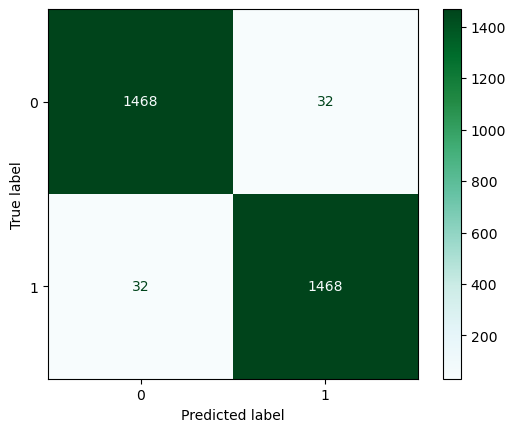

In [98]:
cm_sb = confusion_matrix(y_test_sb, y_pred_sb)
cm_display = ConfusionMatrixDisplay(cm_sb).plot(cmap='BuGn')

### 3.3) SVM con vectorización TF-IDF (10 puntos) 
Para esta parte deben entrenar un modelo SVM con las representaciones vectoriales obtenidas con TF-IDF. Deben utilizar la clase SVC de la librería sklearn. Para esto:
- Deben dejar los datos en un formato adecuado para ser procesados por el modelo (1 pto.)
- Dividir el dataset en train y test (1 pto.)
- Entrenar el modelo SVM con los datos de train (2 ptos.) modificando los hiperparámetros kernel y C (4 ptos.)
- Evaluar el modelo con los datos de test y comentar brevemente los resultados obtenidos (2 ptos.).

In [74]:
X_TFIDF_scaled = scaler.fit_transform(X_TFIDF.toarray())

In [76]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_TFIDF_scaled, Y, test_size=0.3, stratify=Y) 

In [77]:
for kernel_ in kernels:
    for c in c_values:
        if kernel_ == 'poly':
            for degree_ in degrees:
                clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, degree= degree_, C=c))
                clf.fit(X_train_tfidf, y_train_tfidf)
                y_pred_tfidf = clf.predict(X_test_tfidf)
                acc = accuracy_score(y_test_tfidf, y_pred_tfidf)
                print(
                    "For kernel =",
                    kernel_,
                    "with degree =",
                    degree_,
                    "with C value = ",
                    c,
                    "The accuracy is :",
                    acc,
                )
        else:
            clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, C=c))
            clf.fit(X_train_tfidf, y_train_tfidf)
            y_pred_tfidf = clf.predict(X_test_tfidf)
            acc = accuracy_score(y_test_tfidf, y_pred_tfidf)
            print(
                "For kernel =",
                kernel_,
                "with C value = ",
                c,
                "The accuracy is :",
                acc,
            )


For kernel = linear with C value =  0.001 The accuracy is : 0.9973333333333333
For kernel = linear with C value =  0.01 The accuracy is : 0.9976666666666667
For kernel = linear with C value =  0.1 The accuracy is : 0.9976666666666667
For kernel = linear with C value =  1 The accuracy is : 0.9976666666666667
For kernel = linear with C value =  10 The accuracy is : 0.9976666666666667
For kernel = linear with C value =  100 The accuracy is : 0.9976666666666667
For kernel = linear with C value =  1000 The accuracy is : 0.9976666666666667
For kernel = poly with degree = 2 with C value =  0.001 The accuracy is : 0.7523333333333333
For kernel = poly with degree = 3 with C value =  0.001 The accuracy is : 0.6173333333333333
For kernel = poly with degree = 4 with C value =  0.001 The accuracy is : 0.5343333333333333
For kernel = poly with degree = 5 with C value =  0.001 The accuracy is : 0.5026666666666667
For kernel = poly with degree = 6 with C value =  0.001 The accuracy is : 0.5
For kernel

In [78]:
# Dado los resultados anteriores podemos visualizar que los kernels con mas acertividad fueron el kernel gaussiano 
# y el kernel de la funcion Sigmoid, ambos con un valor de 0.998 y parametro C = 1
clf_tfidf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1)) # Escogeremos el kernel rbf 
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



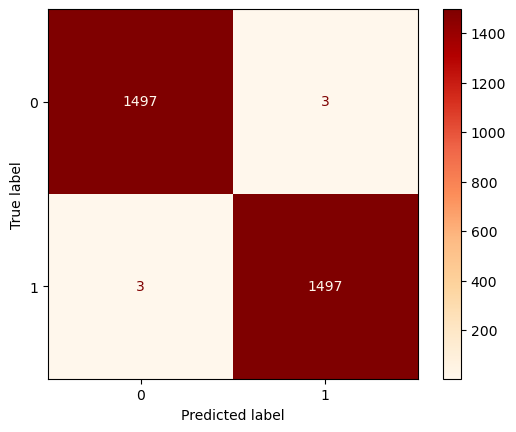

In [93]:
cm_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)
cm_display = ConfusionMatrixDisplay(cm_tfidf).plot(cmap='OrRd')

### 3.4) Análisis de resultados (6 puntos)
- ¿Qué vectorización obtuvo mejores resultados, SBert o TF-IDF? ¿Por qué? (3 ptos.)
- ¿Qué hiperparámetros obtuvieron mejores resultados para cada vectorización? (3 ptos.)

👉🏻

👉🏻

# Parte 4 (Bonus): LIME explainer (5 puntos)

A continuación haz un análisis de los resultados obtenidos con el modelo SVM con vectorización SBert utilizando LIME explainer. Para esto, debes seguir los siguientes pasos:
- Instalar la librería Lime
- Elegir un ejemplo de test
- Utilizar el explainer de Lime para explicar la predicción del modelo en ese ejemplo (2.5 pts.)
- Analizar los resultados obtenidos y comentar brevemente (2.5 pts.)